In [36]:
using Random
Random.seed!(4649373)

using Distributions
using QuadGK
using Roots
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(400, 250))

In [37]:
function winningrate(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution
    )
    quadgk(y -> cdf(distx, y)*pdf(disty, y), extrema(disty)...)[1]
end

function tieshift(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution;
        p = 1/2
    )
    find_zero(0.0) do a
        winningrate(distx + a, disty) - p
    end
end

@show distx = Exponential(1)
@show disty = Exponential(1.5)
@show winningrate(distx, disty)
println()
@show tiesh = tieshift(distx, disty)
@show mediansh = median(disty) - median(distx)
@show meansh = mean(disty) - mean(distx)
println()
@show winningrate(distx + tiesh, disty)
@show winningrate(distx + mediansh, disty)
@show winningrate(distx + meansh, disty)
println()
@show median(distx + tiesh)
@show median(distx + mediansh)
@show median(distx + meansh)
@show median(disty)
println()
@show mean(distx + tiesh)
@show mean(distx + mediansh)
@show mean(distx + meansh)
@show mean(disty)
;

distx = Exponential(1) = Exponential{Float64}(θ=1.0)
disty = Exponential(1.5) = Exponential{Float64}(θ=1.5)
winningrate(distx, disty) = 0.6000000000000003

tiesh = tieshift(distx, disty) = 0.27348233139104033
mediansh = median(disty) - median(distx) = 0.3465735902799726
meansh = mean(disty) - mean(distx) = 0.5

winningrate(distx + tiesh, disty) = 0.5
winningrate(distx + mediansh, disty) = 0.47622031634305906
winningrate(distx + meansh, disty) = 0.4299187894696709

median(distx + tiesh) = 0.9666295119509856
median(distx + mediansh) = 1.0397207708399179
median(distx + meansh) = 1.1931471805599454
median(disty) = 1.0397207708399179

mean(distx + tiesh) = 1.2734823313910404
mean(distx + mediansh) = 1.3465735902799727
mean(distx + meansh) = 1.5
mean(disty) = 1.5


In [38]:
using Distributions

@doc raw"""
    brunner_munzel_test(X, Y; p = 1/2)

この函数は数値のベクトルのデータ `X`, `Y` について, 
Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p}, \quad
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|),
\\ &
\mathrm{p} = p.
\end{aligned}
```
"""
function brunner_munzel_test(X, Y; p=1/2)
    m, n = length(X), length(Y)
    phat = mean((x < y) + (x == y)/2 for x in X, y in Y)
    Hbarx = n*(1 - phat)
    Hbary = m*phat
    sx2 = 1/n^2 * 1/(m-1) * sum(x -> (sum((y < x) + (y == x)/2 for y in Y) - Hbarx)^2, X)
    sy2 = 1/m^2 * 1/(n-1) * sum(y -> (sum((x < y) + (x == y)/2 for x in X) - Hbary)^2, Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
    (; phat, sehat, tvalue, df, pvalue, p)
end

@doc raw"""
    pvalue_brunner_munzel_test(X, Y; p = 1/2)

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
pvalue_brunner_munzel_test(X, Y; p=1/2) = brunner_munzel_test(X, Y; p).pvalue

using RCall
@rimport lawstat
X = rand(100)
Y = rand(100)
pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]

(0.10237071161776065, 0.10237071161776079)

In [39]:
X = fill(1, 100)
Y = fill(0, 100)
@show pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]
brunner_munzel_test(X, Y) |> pairs

(pvalue_brunner_munzel_test(X, Y), (rcopy(lawstat.brunner_munzel_test(X, Y)))[:p_value]) = (0.0, NaN)


pairs(::NamedTuple) with 6 entries:
  :phat   => 0.0
  :sehat  => 0.0
  :tvalue => -Inf
  :df     => NaN
  :pvalue => 0.0
  :p      => 0.5

In [40]:
X = fill(0, 100)
Y = fill(1, 100)
@show pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]
brunner_munzel_test(X, Y) |> pairs

(pvalue_brunner_munzel_test(X, Y), (rcopy(lawstat.brunner_munzel_test(X, Y)))[:p_value]) = (0.0, NaN)


pairs(::NamedTuple) with 6 entries:
  :phat   => 1.0
  :sehat  => 0.0
  :tvalue => Inf
  :df     => NaN
  :pvalue => 0.0
  :p      => 0.5

In [41]:
X = zeros(10^3)
Y = zeros(10^3)
@show pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]
brunner_munzel_test(X, Y) |> pairs

(pvalue_brunner_munzel_test(X, Y), (rcopy(lawstat.brunner_munzel_test(X, Y)))[:p_value]) = (1.0, NaN)


pairs(::NamedTuple) with 6 entries:
  :phat   => 0.5
  :sehat  => 0.0
  :tvalue => NaN
  :df     => NaN
  :pvalue => 1.0
  :p      => 0.5

In [42]:
X = zeros(10^3)
Y = zeros(10^3)
Y[1] += eps()
@show pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]
brunner_munzel_test(X, Y) |> pairs

(pvalue_brunner_munzel_test(X, Y), (rcopy(lawstat.brunner_munzel_test(X, Y)))[:p_value]) = (0.3175526601764657, 0.3175526601764127)


pairs(::NamedTuple) with 6 entries:
  :phat   => 0.5005
  :sehat  => 0.0005
  :tvalue => 1.0
  :df     => 999.0
  :pvalue => 0.317553
  :p      => 0.5

In [43]:
@doc brunner_munzel_test

```
brunner_munzel_test(X, Y; p = 1/2)
```

この函数は数値のベクトルのデータ `X`, `Y` について,  Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

$$
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p}, \quad
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
$$

この函数は以下達の named tuple で返す:

$$
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|),
\\ &
\mathrm{p} = p.
\end{aligned}
$$


In [44]:
function mann_whitney_u_test(X, Y; correct=true)
    m, n = length(X), length(Y)
    phat = mean((x < y) + (x == y)/2 for x in X, y in Y)
    sehat = √((m+n+1)/(12m*n))
    zvalue = (phat - 1/2)/sehat
    correction = correct/(2m*n*sehat)
    pvalue = 2ccdf(Normal(), max(0, abs(zvalue) - correction))
    (; phat, sehat, zvalue, pvalue)
end

pvalue_mann_whitney_u_test(X, Y; correct=true) = mann_whitney_u_test(X, Y; correct).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_mann_whitney_u_test(X, Y), pvalue(ApproximateMannWhitneyUTest(X, Y))

(0.04990007292443201, 0.04990007292443193)

In [45]:
function student_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    S2 = ((m-1)*SX2 + (n-1)*SY2) / (m+n-2)
    sehat2 = S2 * (1/m + 1/n)
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = m + n - 2
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_student_t_test(X, Y; μ = 0.0) = student_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_student_t_test(X, Y), pvalue(EqualVarianceTTest(X, Y))

(0.4389806931272048, 0.4389806931272048)

In [46]:
function welch_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    sehat2 = SX2/m + SY2/n
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = sehat2^2 / ((SX2/m)^2/(m-1) + (SY2/n)^2/(n-1))
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_welch_t_test(X, Y; μ = 0.0) =welch_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_welch_t_test(X, Y), pvalue(UnequalVarianceTTest(X, Y))

(0.7219945156946428, 0.7219945156946428)

In [47]:
"""
gammadist(σ, β)

returns the gamma distribution with standard deviation `σ` and skewness `β`.
"""
gammadist(σ, β) = β == 0 ? Normal(0, σ) : Gamma(4/β^2, β*σ/2)

gam = gammadist.(1:5, 2:2:10)
[std.(gam), skewness.(gam), kurtosis.(gam), shape.(gam)]

4-element Vector{Vector{Float64}}:
 [1.0, 2.0, 3.0, 4.0, 5.0]
 [2.0, 4.0, 6.0, 8.0, 10.0]
 [6.0, 24.0, 54.0, 96.0, 150.0]
 [1.0, 0.25, 0.1111111111111111, 0.0625, 0.04]

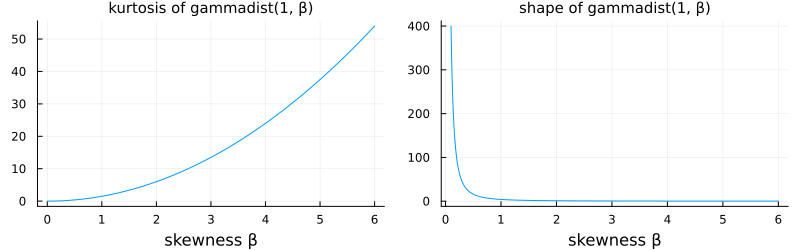

In [48]:
β = range(eps(), 6, 1000)
P = plot(β, β -> kurtosis(gammadist(1, β)); label="")
plot!(xguide="skewness β", yguide="", title="kurtosis of gammadist(1, β)")

β = range(0.1, 6, 1000)
Q = plot(β, β -> shape(gammadist(1, β)); label="")
plot!(xguide="skewness β", yguide="", title="shape of gammadist(1, β)")

plot(P, Q; size=(800, 250))
plot!(bottommargin=4Plots.mm)

In [49]:
@doc gammadist

gammadist(σ, β)

returns the gamma distribution with standard deviation `σ` and skewness `β`.


In [50]:
"""
inversegammadist(σ, β)

returns the inverse gamma distribution with standard deviation `σ` and skewness `β`.
"""
function inversegammadist(σ, β)
    β == 0 && return Normal(0, σ)
    α = 3 + 8/β^2 + 4/β * √(1 + 4/β^2)
    θ = σ * (α - 1) * √(α - 2)
    InverseGamma(α, θ)
end

igam = inversegammadist.(1:5, 2:2:10)
[std.(igam), skewness.(igam), kurtosis.(igam), shape.(igam)]

4-element Vector{Vector{Float64}}:
 [0.9999999999999999, 2.0, 3.0, 3.9999999999999996, 5.0]
 [2.0, 4.0, 6.0, 7.999999999999998, 10.0]
 [9.134446499564898, 72.54101966249682, NaN, NaN, NaN]
 [7.82842712474619, 4.618033988749895, 3.9249505911485287, 3.6403882032022077, 3.487921561087423]

In [51]:
c = find_zero(β -> 3 + 8/β^2 + 4/β * √(1 + 4/β^2) - 4.0, 3.0)

5.65685424949238

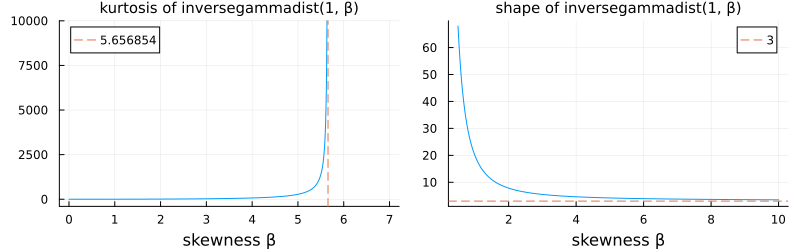

In [52]:
β = range(eps(), 7, 1000)
P = plot(β, β -> kurtosis(inversegammadist(1, β)); label="")
vline!([c]; label="$(round(c; digits=6))", ls=:dash)
plot!(xtick=0:10, ylim=(-400, 10000))
plot!(xguide="skewness β", yguide="", title="kurtosis of inversegammadist(1, β)")

β = range(0.5, 10, 1000)
Q = plot(β, β -> shape(inversegammadist(1, β)); label="")
hline!([3]; label="3", ls=:dash)
plot!(xguide="skewness β", yguide="", title="shape of inversegammadist(1, β)")

plot(P, Q; size=(800, 250))
plot!(bottommargin=4Plots.mm)

In [53]:
@doc inversegammadist

inversegammadist(σ, β)

returns the inverse gamma distribution with standard deviation `σ` and skewness `β`.


In [54]:
undefarray(T::Type, n...) = Array{T}(undef, n...)
undefarray(n...) = undefarray(Float64, n...)
ECDF(A, x) = count(≤(x), A) / length(A)

list_skewness = Tuple((β, β) for β in 0:0.5:3)
list_skewness2 = Tuple((β, β-0.5) for β in 1:0.5:3)
list_stdratio = reverse((1.0, 1.1, 1.25, 1.5, 2.0))

rd(x) = round(100x; digits=1)

function print_sim(;
        list_skewness=list_skewness,
        list_stdratio = list_stdratio,
        distfunc = gammadist,
        distfuncx = distfunc,
        distfuncy = distfunc,
        α = 0.05,
        L = 10^5,
        m = 25,
        n = 25,
        shifttype = :auto,
        correct = true,
    )
    
    nx = length(list_skewness)
    ny = length(list_stdratio)
    # `er` stands for "true alpha Error Rate".
    er_wmw = undefarray(nx, ny)
    er_bm = undefarray(nx, ny)
    er_st = undefarray(nx, ny)
    er_we = undefarray(nx, ny)
    
    for (i, (β1, β2)) in enumerate(list_skewness), (j, σ) in enumerate(list_stdratio)
        distx = distfuncx(σ, β1)
        disty = distfuncy(1, β2)
        (; pval_wmw, pval_bm, pval_st, pval_we) = sim(distx, disty, m, n; shifttype, correct, L)
        er_wmw[i, j] = ECDF(pval_wmw, α)
        er_bm[i, j] = ECDF(pval_bm, α)
        er_st[i, j] = ECDF(pval_st, α)
        er_we[i, j] = ECDF(pval_we, α)
    end
    
    println("skewness = ", list_skewness)
    println("stdratio = ", list_stdratio)
    println("distx = $distfuncx,  disty = $distfuncy, m = $m,  n = $n,  shifttype = $shifttype")
    println()
    println("Wilcoxon-Mann-Whitney:"); Base.print_matrix(stdout, rd.(er_wmw'))
    println("\n\nBrunner-Munzel:"); Base.print_matrix(stdout, rd.(er_bm'))
    println("\n\nStudent t:"); Base.print_matrix(stdout, rd.(er_st'))
    println("\n\nWelch t:"); Base.print_matrix(stdout, rd.(er_we'))
    println("\n")
end

function sim(distx, disty, m, n; shifttype=:mean, correct=true, L=10^5)
    meansh = mean(disty) - mean(distx)
    mediansh = median(disty) - median(distx)
    tiesh = tieshift(distx, disty)
    if shifttype == :mean
        distx_sh = distx + meansh
    elseif shifttype == :median
        distx_sh = distx + mediansh
    elseif shifttype == :tie || shifttype == :auto
        distx_sh = distx + tiesh
    else
        distx_sh = distx
    end
    
    pval_wmw = undefarray(L)
    pval_bm = undefarray(L)
    pval_st = undefarray(L)
    pval_we = undefarray(L)
    nth = Threads.nthreads()
    Xtmp = [undefarray(m) for _ in 1:nth]
    Ytmp = [undefarray(n) for _ in 1:nth]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx_sh, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
        pval_wmw[i] = pvalue_mann_whitney_u_test(X, Y; correct)
        pval_bm[i] = pvalue_brunner_munzel_test(X, Y)
        if shifttype == :auto
            @. X = X - tiesh + meansh
        end
        pval_st[i] = pvalue_student_t_test(X, Y)
        pval_we[i] = pvalue_welch_t_test(X, Y)
    end
    
    (; pval_wmw, pval_bm, pval_st, pval_we)
end

function print_sim(distx, disty, m, n; shifttype=:mean, L=10^5, α=0.05)
    (; pval_wmw, pval_bm, pval_st, pval_we) = sim(distx, disty, m, n; shifttype, L)
    er_wmw = ECDF(pval_wmw, α)
    er_bm = ECDF(pval_bm, α)
    er_st = ECDF(pval_st, α)
    er_we = ECDF(pval_we, α)
    println("distx = $distx")
    println("disty = $disty")
    println("m = $m,  n = $n,  shifttype = $shifttype")
    println()
    println("Wilcoxon-Mann-Whitney: ", rd(er_wmw), "%")
    println("Brunner-Munzel:        ", rd(er_bm), "%")
    println("Student t:             ", rd(er_st), "%")
    println("Welch t:               ", rd(er_we), "%")
    println()
end

print_sim (generic function with 2 methods)

In [91]:
1

1

In [92]:
gammadist2(μ, σ) = Gamma(μ^2/σ^2, σ^2/μ)
[
    [shape(gammadist2(3, σ)) for σ in (√3, √3/2, √3/3, √3/4)],
    [scale(gammadist2(3, σ)) for σ in (√3, √3/2, √3/3, √3/4)],
    [mean(gammadist2(3, σ)) for σ in (√3, √3/2, √3/3, √3/4)],
    [var(gammadist2(3, σ)) for σ in (√3, √3/2, √3/3, √3/4)],
    [std(gammadist2(3, σ)) for σ in (√3, √3/2, √3/3, √3/4)]
]

5-element Vector{Vector{Float64}}:
 [3.0000000000000004, 12.000000000000002, 27.0, 48.00000000000001]
 [0.9999999999999999, 0.24999999999999997, 0.1111111111111111, 0.06249999999999999]
 [3.0, 3.0, 3.0, 3.0]
 [2.9999999999999996, 0.7499999999999999, 0.3333333333333333, 0.18749999999999997]
 [1.7320508075688772, 0.8660254037844386, 0.5773502691896257, 0.4330127018922193]

In [93]:
# 等母平均の場合: この場合はWMW検定とBM検定にとって不利な状況になっている.

for σ in (√3, √3/2, √3/3, √3/4)
    println("-"^20, " 標準治療側の標準偏差 = $(round(√3; digits=2)),  試験治療側の標準偏差 = $(round(σ; digits=2))")
    print_sim(gammadist2(3, √3), gammadist2(3, σ), 100, 100; shifttype=:mean)
end

-------------------- 標準治療側の標準偏差 = 1.73,  試験治療側の標準偏差 = 1.73
distx = Gamma{Float64}(α=3.0000000000000004, θ=0.9999999999999999)
disty = Gamma{Float64}(α=3.0000000000000004, θ=0.9999999999999999)
m = 100,  n = 100,  shifttype = mean

Wilcoxon-Mann-Whitney: 4.8%
Brunner-Munzel:        4.9%
Student t:             4.8%
Welch t:               4.8%

-------------------- 標準治療側の標準偏差 = 1.73,  試験治療側の標準偏差 = 0.87
distx = Gamma{Float64}(α=3.0000000000000004, θ=0.9999999999999999)
disty = Gamma{Float64}(α=12.000000000000002, θ=0.24999999999999997)
m = 100,  n = 100,  shifttype = mean

Wilcoxon-Mann-Whitney: 25.2%
Brunner-Munzel:        23.0%
Student t:             5.2%
Welch t:               5.2%

-------------------- 標準治療側の標準偏差 = 1.73,  試験治療側の標準偏差 = 0.58
distx = Gamma{Float64}(α=3.0000000000000004, θ=0.9999999999999999)
disty = Gamma{Float64}(α=27.0, θ=0.1111111111111111)
m = 100,  n = 100,  shifttype = mean

Wilcoxon-Mann-Whitney: 36.4%
Brunner-Munzel:        31.2%
Student t:             5.2%
Welch 

In [94]:
# フェアな比較: WMWとBMでは P(X<Y)+P(X=Y)/2 = 1/2 という状況で確認を行う.

for σ in (√3, √3/2, √3/3, √3/4)
    println("-"^20, " 標準治療側の標準偏差 = $(round(√3; digits=2)),  試験治療側の標準偏差 = $(round(σ; digits=2))")
    print_sim(gammadist2(3, √3), gammadist2(3, σ), 100, 100; shifttype=:auto)
end

-------------------- 標準治療側の標準偏差 = 1.73,  試験治療側の標準偏差 = 1.73
distx = Gamma{Float64}(α=3.0000000000000004, θ=0.9999999999999999)
disty = Gamma{Float64}(α=3.0000000000000004, θ=0.9999999999999999)
m = 100,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney: 5.0%
Brunner-Munzel:        5.1%
Student t:             5.0%
Welch t:               5.0%

-------------------- 標準治療側の標準偏差 = 1.73,  試験治療側の標準偏差 = 0.87
distx = Gamma{Float64}(α=3.0000000000000004, θ=0.9999999999999999)
disty = Gamma{Float64}(α=12.000000000000002, θ=0.24999999999999997)
m = 100,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney: 5.7%
Brunner-Munzel:        5.0%
Student t:             5.1%
Welch t:               5.0%

-------------------- 標準治療側の標準偏差 = 1.73,  試験治療側の標準偏差 = 0.58
distx = Gamma{Float64}(α=3.0000000000000004, θ=0.9999999999999999)
disty = Gamma{Float64}(α=27.0, θ=0.1111111111111111)
m = 100,  n = 100,  shifttype = auto

Wilcoxon-Mann-Whitney: 6.8%
Brunner-Munzel:        5.1%
Student t:             5.4%
Welch t:  